# Library Imports and Data Set Up

In [ ]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sqlite3
import seaborn as sns
from google.colab import drive
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import defaultdict



In [ ]:
# Uploading db file and syncing database
drive.mount('/content/gdrive')
conn = sqlite3.connect('/content/gdrive/MyDrive/CS_4641/database.db')

Mounted at /content/gdrive


# Data Cleaning 

## Extracting Relevant Features

In [ ]:
team_data = pd.read_sql("SELECT * FROM Team;", conn) # team_specific data with name and api id
team_attribute_data = pd.read_sql("SELECT * FROM Team_Attributes", conn) # team_attribute data 
match_data = pd.read_sql("SELECT * FROM Match;", conn) # all matches from 2008-2016

# Select only scorelines and teams playing in match
match_data = match_data[['match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal']]

# Drop all the play type classifier variables in attributes
team_attribute_data.drop(['buildUpPlaySpeedClass', 'buildUpPlayDribbling', 'buildUpPlayPassingClass', 'chanceCreationShootingClass', 'chanceCreationPositioningClass', 'defencePressureClass', 'defenceAggressionClass', 'defenceTeamWidthClass', 'defenceDefenderLineClass', 'buildUpPlayPositioningClass', 'chanceCreationPassingClass', 'chanceCreationCrossingClass'], axis=1, inplace=True)
team_attribute_data.replace({'Little':0, 'Normal':1, 'Lots':2}, inplace=True)

# team_attribute_data
# match_data


## Data Processing Functions

In [ ]:
# params: None
# Function gets the team win ratio for each team over all the matches played in the data set
def get_win_ratio():
  total_matches_played = defaultdict(int)
  team_wins = defaultdict(int)
  win_ratio = defaultdict(int)

  for index, row in match_data.iterrows():

    # Increment total matches
    total_matches_played[row['home_team_api_id']] += 1
    total_matches_played[row['away_team_api_id']] += 1

    # Find out who won
    if row['home_team_goal'] > row['away_team_goal']:
      team_wins[row['home_team_api_id']] += 1
    elif row['home_team_goal'] < row['away_team_goal']:
      team_wins[row['away_team_api_id']] += 1
    
  for team, value in total_matches_played.items():
    win_ratio[team] = team_wins[team] / total_matches_played[team]

  return win_ratio

win_ratio = get_win_ratio()

In [ ]:

# params: match - row of the match df
# This function takes in a match and returns all the team_specific attributes for the home and the away team as a dataframe
def get_team_stats_for_match(match):
  home_team_id = match.home_team_api_id
  away_team_id = match.away_team_api_id
  # Retrieve the home and away team attributes. 
  home_team_data = get_team_attributes(home_team_id).add_prefix('home_')
  away_team_data = get_team_attributes(away_team_id).add_prefix('away_')
  # Combine both team stats
  combined = pd.concat([home_team_data, away_team_data])
  return combined

# params: team_api_id - unique team identifier.
# Function gets the team stats for a specific team, and then averages across multiple instances.
def get_team_attributes(team_api_id):
  team_data = team_attribute_data.loc[team_attribute_data['team_api_id'] == team_api_id]
  team_data.drop(['id', 'date', 'team_fifa_api_id', 'team_api_id'], axis=1, inplace=True)

  dribble_class = team_data['buildUpPlayDribblingClass'].mode() # pick most frequence dribblingClass assignment as chosen value instead of averaging out

  data = team_data.mean()
  if not dribble_class.empty:
    data['buildUpPlayDribblingClass'] = dribble_class[0]
  data['win_percentage'] = win_ratio[team_api_id]
  return data
  
# params: dif - the goal difference
# Function returns if the home team won or the away team won
def get_winloss_num(dif):
  if dif < 0:
    return 0 # away won
  elif dif > 0:
    return 2 # home won
  else:
    return 1 # tie

def get_winloss_num_binary(dif):
    if dif > 0:
      return 1
    else:
      return 0



## Combining Team attribute data with Match Data

In [ ]:
df = match_data.copy()
# df = match_data.head(7)
# print(df)
# print(df['match_api_id'])

new_cols = df.apply(lambda row: get_team_stats_for_match(row), axis=1)
df = pd.concat([df, new_cols], axis=1)
df = df.dropna()
match_data_with_team_attributes = df
match_data_with_team_attributes


,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_buildUpPlaySpeed,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,...,away_buildUpPlaySpeed,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,away_win_percentage
0,492473,9987,9993,1,1,56.333333,0.0,44.333333,55.666667,52.333333,...,46.000000,0.0,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000,0.263158
1,492474,10000,9994,0,0,55.500000,0.0,52.666667,50.000000,49.333333,...,64.000000,0.0,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000,0.349057
2,492475,9984,8635,0,3,53.666667,0.0,44.166667,59.000000,60.333333,...,51.333333,0.0,45.166667,63.500000,55.000000,51.333333,59.666667,47.666667,63.833333,0.641509
3,492476,9991,9998,5,0,54.166667,0.0,46.333333,44.500000,64.666667,...,51.666667,0.0,51.666667,55.000000,60.666667,46.000000,46.000000,45.000000,47.000000,0.265957
5,492478,8203,8342,1,1,56.666667,0.0,47.333333,47.500000,49.833333,...,49.166667,0.0,46.500000,48.833333,55.833333,47.666667,53.666667,53.833333,54.666667,0.580189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,1992089,10243,10191,3,3,56.833333,0.0,50.000000,48.000000,55.166667,...,56.600000,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000,0.331776
25974,1992091,10190,10191,1,0,47.600000,0.0,51.800000,39.800000,45.200000,...,56.600000,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000,0.331776
25975,1992092,9824,10199,1,2,53.000000,0.0,56.000000,38.000000,53.000000,...,51.833333,0.0,52.500000,53.000000,48.333333,61.000000,48.000000,48.333333,50.333333,0.367133
25976,1992093,9956,10179,2,0,49.500000,0.0,53.166667,53.000000,58.666667,...,54.333333,0.0,44.000000,60.833333,52.666667,54.333333,42.666667,43.833333,50.000000,0.363636


In [ ]:
df = match_data_with_team_attributes.copy()
df['winloss'] = df['home_team_goal'] - df['away_team_goal']
df['winloss'] = df['winloss'].apply(get_winloss_num_binary)
df.drop(['match_api_id', 'home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal'], axis=1, inplace=True)
data_complete = df
data_complete
# Data preprocessing stops here

,home_buildUpPlaySpeed,home_buildUpPlayDribblingClass,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,home_win_percentage,...,away_buildUpPlayDribblingClass,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth,away_win_percentage,winloss
0,56.333333,0.0,44.333333,55.666667,52.333333,55.833333,49.166667,50.666667,59.833333,0.457547,...,0.0,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000,0.263158,0
1,55.500000,0.0,52.666667,50.000000,49.333333,41.500000,48.666667,56.166667,47.833333,0.367925,...,0.0,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000,0.349057,0
2,53.666667,0.0,44.166667,59.000000,60.333333,48.000000,60.166667,49.666667,64.666667,0.318681,...,0.0,45.166667,63.500000,55.000000,51.333333,59.666667,47.666667,63.833333,0.641509,0
3,54.166667,0.0,46.333333,44.500000,64.666667,44.166667,51.333333,50.000000,45.666667,0.500000,...,0.0,51.666667,55.000000,60.666667,46.000000,46.000000,45.000000,47.000000,0.265957,1
5,56.666667,0.0,47.333333,47.500000,49.833333,50.333333,47.666667,58.833333,52.000000,0.372642,...,0.0,46.500000,48.833333,55.833333,47.666667,53.666667,53.833333,54.666667,0.580189,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25972,56.833333,0.0,50.000000,48.000000,55.166667,53.500000,48.666667,46.000000,55.666667,0.419580,...,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000,0.331776,0
25974,47.600000,0.0,51.800000,39.800000,45.200000,44.400000,43.800000,45.600000,50.800000,0.333333,...,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000,0.331776,1
25975,53.000000,0.0,56.000000,38.000000,53.000000,46.000000,42.000000,33.000000,58.000000,0.175926,...,0.0,52.500000,53.000000,48.333333,61.000000,48.000000,48.333333,50.333333,0.367133,0
25976,49.500000,0.0,53.166667,53.000000,58.666667,50.333333,37.833333,46.666667,51.666667,0.402098,...,0.0,44.000000,60.833333,52.666667,54.333333,42.666667,43.833333,50.000000,0.363636,1


In [ ]:
df = team_data.copy()
new_cols = df.apply(lambda row: get_team_attributes(row['team_api_id']), axis=1)
df = pd.concat([df, new_cols], axis=1)
df = df.dropna()
team_data_with_attributes = df
team_data_with_attributes

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,buildUpPlaySpeed,buildUpPlayDribblingClass,buildUpPlayPassing,chanceCreationPassing,chanceCreationCrossing,chanceCreationShooting,defencePressure,defenceAggression,defenceTeamWidth,win_percentage
0,1,9987,673.0,KRC Genk,GEN,56.333333,0.0,44.333333,55.666667,52.333333,55.833333,49.166667,50.666667,59.833333,0.457547
1,2,9993,675.0,Beerschot AC,BAC,46.000000,0.0,41.500000,46.000000,53.500000,53.750000,48.250000,49.000000,58.750000,0.263158
2,3,10000,15005.0,SV Zulte-Waregem,ZUL,55.500000,0.0,52.666667,50.000000,49.333333,41.500000,48.666667,56.166667,47.833333,0.367925
3,4,9994,2007.0,Sporting Lokeren,LOK,64.000000,0.0,53.500000,44.000000,47.666667,54.333333,48.833333,55.166667,55.500000,0.349057
4,5,9984,1750.0,KSV Cercle Brugge,CEB,53.666667,0.0,44.166667,59.000000,60.333333,48.000000,60.166667,49.666667,64.666667,0.318681
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293,49124,10243,894.0,FC Zürich,ZUR,56.833333,0.0,50.000000,48.000000,55.166667,53.500000,48.666667,46.000000,55.666667,0.419580
294,49479,10190,898.0,FC St. Gallen,GAL,47.600000,0.0,51.800000,39.800000,45.200000,44.400000,43.800000,45.600000,50.800000,0.333333
295,49837,10191,1715.0,FC Thun,THU,56.600000,0.0,35.800000,63.200000,36.400000,59.000000,45.000000,42.800000,51.600000,0.331776
296,50201,9777,324.0,Servette FC,SER,42.000000,0.0,52.333333,50.333333,67.333333,50.000000,51.000000,50.000000,51.000000,0.285714


# Machine Learning Models

## PCA

                                     PC0       PC1       PC2       PC3  \
home_buildUpPlaySpeed          -0.166155 -0.056861 -0.403306 -0.316841   
home_buildUpPlayDribblingClass  0.152780 -0.126025  0.009112  0.068122   
home_buildUpPlayPassing        -0.043734 -0.215592 -0.392828 -0.339232   
home_chanceCreationPassing     -0.214513  0.120541 -0.183151 -0.386690   
home_chanceCreationCrossing    -0.103302  0.060478 -0.236443 -0.322296   
home_chanceCreationShooting    -0.222437  0.229128  0.084714 -0.015805   
home_defencePressure           -0.358308  0.348663  0.135104  0.081920   
home_defenceAggression         -0.291047  0.185724 -0.065863 -0.064859   
home_defenceTeamWidth          -0.318489  0.243881  0.039676 -0.011645   
home_win_percentage            -0.198951  0.381902  0.100055  0.080027   
away_buildUpPlaySpeed          -0.165514 -0.077204 -0.393738  0.333506   
away_buildUpPlayDribblingClass  0.152062  0.123970 -0.026035 -0.055946   
away_buildUpPlayPassing        -0.0480

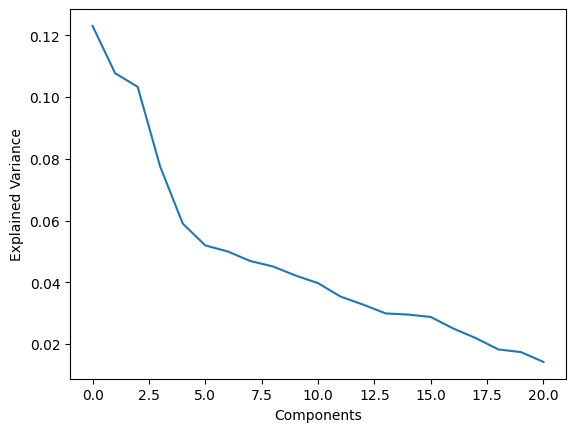

In [ ]:
# Machine Learning Code
df = data_complete.copy()
train, test = train_test_split(df, test_size=0.2) 

# normalize training data. 
df = train
df_normalized=(df - df.mean()) / df.std() # Redundant 
df_normalized

# You must normalize the data before applying the fit method
df_normalized=(df - df.mean()) / df.std()
pca = PCA(n_components=df.shape[1])
pca.fit(df_normalized)

# Reformat and view results
loadings = pd.DataFrame(pca.components_.T,
columns=['PC%s' % _ for _ in range(len(df_normalized.columns))],
index=df.columns)
print(loadings)

plt.plot(pca.explained_variance_ratio_)
plt.ylabel('Explained Variance')
plt.xlabel('Components')
plt.show()

## Logistic Regression

In [ ]:
df = data_complete.copy()
x_train, x_test, y_train, y_test = train_test_split(df.drop('winloss', axis=1), df['winloss'], test_size=0.2, random_state=0)

# pca = PCA(n_components=15)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

lda = LinearDiscriminantAnalysis()
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

# logreg = LogisticRegression()
# rfe = RFE(estimator=logreg, n_features_to_select=5)
# rfe.fit(x_train, y_train)
# # selected_features = X_train.columns[rfe.support_]
# x_train = rfe.transform(x_train)
# x_test = rfe.transform(x_test)

logreg = LogisticRegression(max_iter = 1000)
# logreg = LogisticRegression(max_iter = 1000, multi_class='multinomial', solver='lbfgs')
logreg.fit(x_train, y_train)
y_pred = logreg.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.6500195083886071
Precision: 0.6505907542407516
Recall: 0.6412208751297976
F1-score: 0.6400280898876405


In [ ]:
df = data_complete.copy()
x_train, x_test, y_train, y_test = train_test_split(df.drop('winloss', axis=1), df['winloss'], test_size=0.2, random_state=0)
# specify hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2', 'None'], 
    'C': [0.001, 0.01, 0.1, 1, 10, 100], 
    'solver': ['liblinear', 'saga']
}
# instantiate logistic regression model
logreg = LogisticRegression(max_iter=1000)
# instantiate grid search
grid_search = GridSearchCV(estimator=logreg, param_grid=param_grid, cv=5, scoring='f1')

# fit grid search to data
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print(best_params)
y_pred = logreg.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means 

{'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}


NotFittedError: ignored

## Random Forest

In [ ]:
# Random Forest Algorithm
df = data_complete.copy()
x_train, x_test, y_train, y_test = train_test_split(df.drop('winloss', axis=1), df['winloss'], test_size=0.2, random_state=0)

# pca = PCA(n_components=15)
# x_train = pca.fit_transform(x_train)
# x_test = pca.transform(x_test)

lda = LinearDiscriminantAnalysis()
x_train = lda.fit_transform(x_train, y_train)
x_test = lda.transform(x_test)

rf_classifier = RandomForestClassifier(n_estimators = 200, random_state = 1, class_weight = 'balanced')

rf_classifier.fit(x_train, y_train)
y_pred = rf_classifier.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred, average='macro'))
print('Recall:', recall_score(y_test, y_pred, average='macro'))
print('F1-score:', f1_score(y_test, y_pred, average='macro'))

Accuracy: 0.5903238392508778
Precision: 0.5894715917745621
Recall: 0.5899064293900982
F1-score: 0.589331327969861


# K-Means

In [ ]:
# Extract the features you want to cluster on
df = team_data_with_attributes.copy()
exclude_columns = ['id', 	'team_api_id',	'team_fifa_api_id', 'team_long_name',	'team_short_name']
X = df.loc[:, ~df.columns.isin(exclude_columns)]
# print(X)

# Create a KMeans model with 3 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the model to the data
kmeans.fit(X)

# Get the cluster labels for each data point
labels = kmeans.labels_

# Add the cluster labels to the DataFrame
df['cluster'] = labels

# print(df)
counts = df['cluster'].value_counts()
print(counts)


# Man U 10260
# Man City 8456
ids = [10260, 8456, 8633, 8650, 9906, 9823, 8634]
for team_api_id in ids:
  team = df.loc[df['team_api_id'] == team_api_id]
  print(team[['team_long_name', 'cluster']])
# df

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


0    145
1    143
Name: cluster, dtype: int64
       team_long_name  cluster
25  Manchester United        1
     team_long_name  cluster
34  Manchester City        0
     team_long_name  cluster
256  Real Madrid CF        1
   team_long_name  cluster
30      Liverpool        0
      team_long_name  cluster
269  Atlético Madrid        1
      team_long_name  cluster
94  FC Bayern Munich        0
    team_long_name  cluster
258   FC Barcelona        0


# Data Visualization Figures

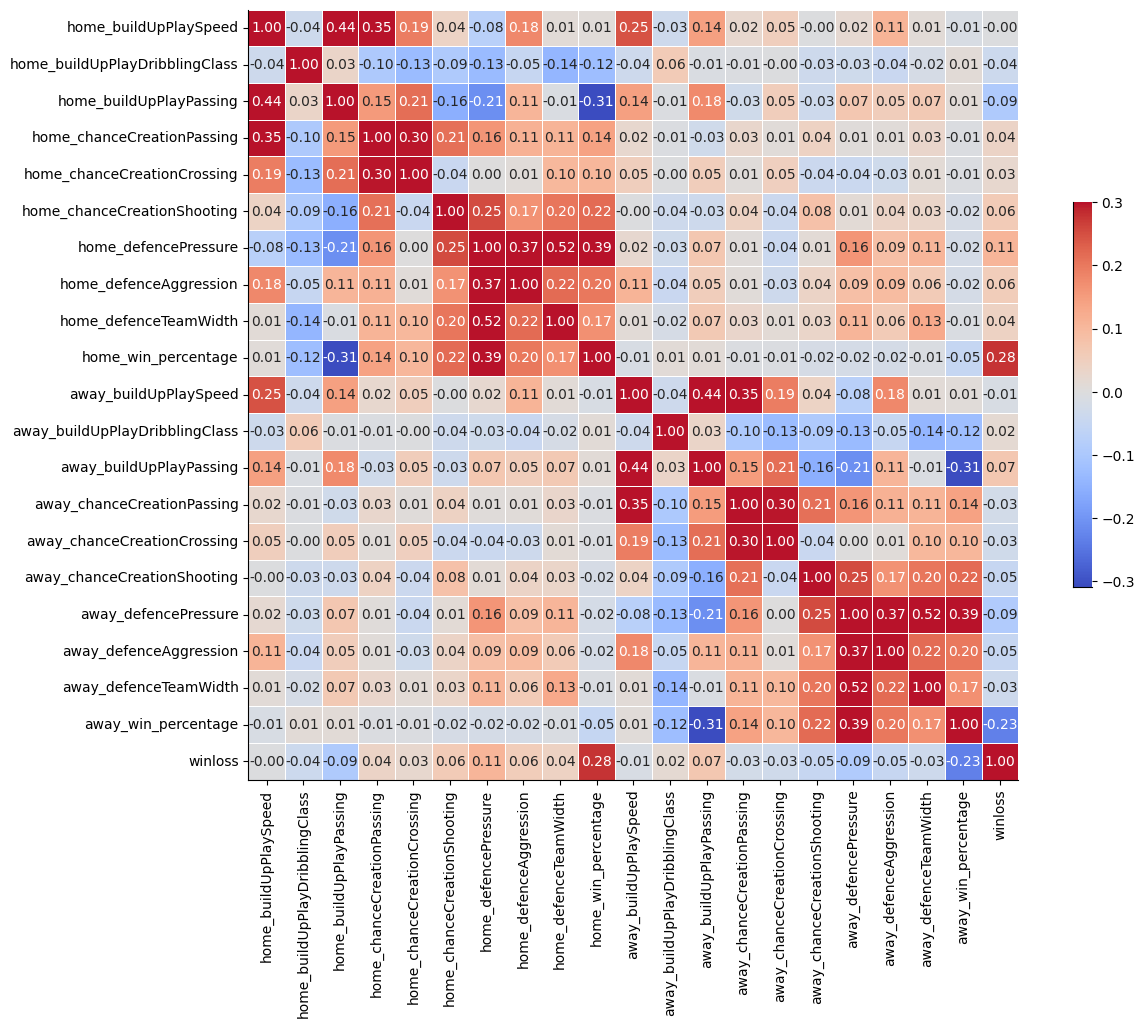

In [ ]:
df = data_complete.copy()
corr = df.corr()

g = sns.heatmap(corr,  vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True, fmt='.2f', cmap='coolwarm')

sns.despine()
g.figure.set_size_inches(14,10)
    
plt.show()

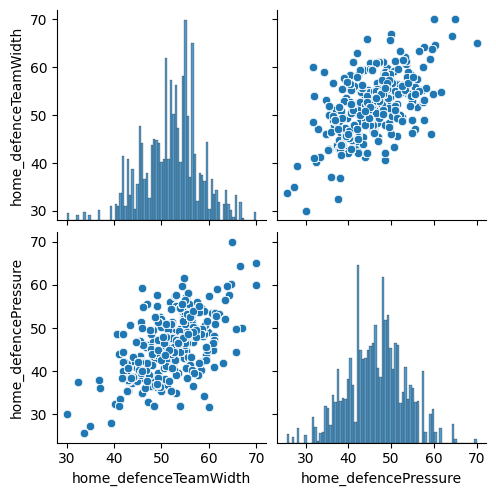

In [ ]:
g = sns.pairplot(match_data_with_team_attributes[['home_defenceTeamWidth','home_defencePressure']])


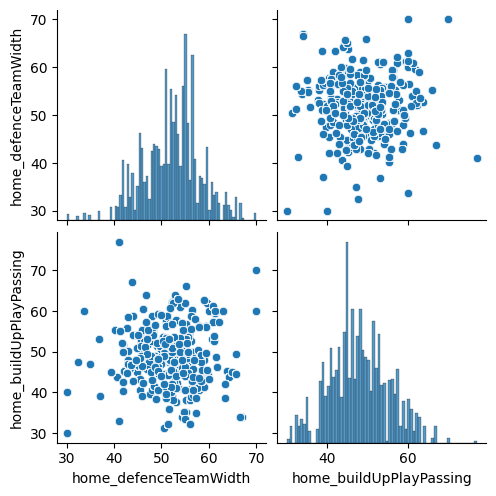

In [ ]:
# g = sns.pairplot(match_data_with_team_attributes[['home_buildUpPlaySpeed','home_buildUpPlayPassing','home_chanceCreationPassing']])
g = sns.pairplot(match_data_with_team_attributes[['home_defenceTeamWidth','home_buildUpPlayPassing']])


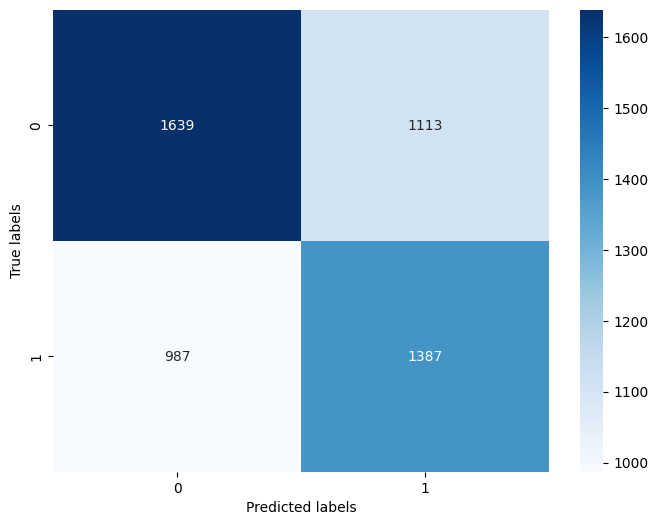

In [ ]:
# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()